In [55]:
import copy
import os
import csv
import string
from itertools import repeat
from multiprocessing.pool import ThreadPool as Pool
import pycountry
import langcodes
import sqlalchemy
from datetime import datetime
import seaborn as sns

import numpy as np
import pandas as pd
from typing import Dict, List, Set, Tuple
from collections import Counter

from PIL import Image
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer, Tokenizer
from ekphrasis.dicts.emoticons import emoticons

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import download
from nltk import pos_tag

import tensorflow as tf
import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import official.nlp.optimization
# import official.nlp.bert.bert_models
# import official.nlp.bert.configs
# import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

from pymongo import MongoClient
import yaml
from mysql.connector import (connection)
from mysql.connector.connection import MySQLConnection
from mysql.connector.errors import IntegrityError

In [39]:
def get_pandas_dtype(value = None, is_categorical = False):
    if isinstance(value, float):
        return "float64"
    elif isinstance(value, int):
        return "int64"
    elif isinstance(value, str):
        return "string"
    elif isinstance(value, bool):
        return "boolean"
    elif is_categorical:
        return "categorical"
    else:
        return "object"


def duplicated_column_value_count(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    dup_count_df = df.pivot_table(columns=columns, aggfunc='size')
    return dup_count_df[dup_count_df[:] > 1]


def duplicate_count(df: pd.DataFrame) -> pd.DataFrame:
    data = {}
    for column in df.columns:
        data[column] = duplicated_column_value_count(df, column).sum()

    dup_count_df = pd.DataFrame(data, index=['duplicates'])
    return dup_count_df.T


def filter_by_word_count(df: pd.DataFrame, column_name: str, word_count: int = 10) \
        -> pd.DataFrame:
    count = df[column_name].str.split().str.len()
    return df[count >= word_count]


def fetch_all_mysql_tablenames(db: MySQLConnection) -> pd.DataFrame:
    db_cursor = db.cursor()
    db_cursor.execute('SHOW TABLES;')
    tb_data = { 'table_name': [x[0] for x in db_cursor.fetchall()] }
    db_cursor.close()
    return pd.DataFrame(data=tb_data, dtype=str)


def load_mongodb_collection_in_dataframe(db_cursor: MongoClient, collection_name: str) -> pd.DataFrame:
    return pd.DataFrame(db_cursor[collection_name].find())


def get_text_preprocessor(normalize: list = ['url', 'email', 'percent', 'money', 'phone',
                                             'user', 'time', 'date', 'number'],
                          annotate: list = {"hashtag", "allcaps", "elongated", "repeated",
                                            'emphasis', 'censored'},
                          fix_html: bool = True,
                          segmenter: str = "twitter",
                          corrector: str = "twitter",
                          unpack_hashtags: bool = True,
                          unpack_contractions: bool = True,
                          spell_correction: bool = True,
                          spell_correct_elong: bool = False,
                          all_caps_tag: str = 'wrap',
                          tokenizer: object = None,
                          dicts: list = [emoticons],
                          pipeline: list = ["URL", "EMOJI", "TAG", "EMAIL", "USER", "HASHTAG", "CASHTAG", "PHONE", "PERCENT", "MONEY", "DATE", "TIME", "ACRONYM",
                                            "LTR_FACE", "RTL_FACE", "CENSORED", "EMPHASIS", "REST_EMOTICONS", "NUMBER", "WORD", "EASTERN_EMOTICONS"]) \
        -> TextPreProcessor:
    if tokenizer is None:
        tokenizer = Tokenizer(pipeline=pipeline, lowercase=True).tokenize

    return TextPreProcessor(
        normalize=normalize,
        annotate=annotate,
        fix_html=fix_html,
        segmenter=segmenter,
        corrector=corrector,
        unpack_hashtags=unpack_hashtags,
        unpack_contractions=unpack_contractions,
        spell_correction=spell_correction,
        spell_correct_elong=spell_correct_elong,
        all_caps_tag=all_caps_tag,
        tokenizer=tokenizer,
        dicts=dicts
    )


def plot_wordcloud(posts: str, stopwords: list = [], max_words: int = 50, use_stopwords_pack: bool = False) -> None:
    if use_stopwords_pack:
        stopwords.extend(STOPWORDS)
        stopwords.extend(sw.words('english'))

    stopwords = set(stopwords)
    wordcloud = WordCloud(width=800, height=800, max_words=max_words, stopwords=stopwords, background_color='black', collocations=False)\
        .generate(posts)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


def word_frequency(posts: pd.DataFrame, post_column_name: str, max_top_rank: int = 50) -> Counter:
    post_corpus = " ".join(posts[post_column_name].fillna('').tolist()).split(" ")
    post_corpus = " ".join(post_corpus)
    return Counter(WordCloud(max_words=max_top_rank, background_color='white', collocations=False)
                   .process_text(post_corpus)).most_common(max_top_rank)


def load_emojis_emoticon(csv_file: str, emo_key: str, emo_value: str) -> Dict:
    csv_file = open(csv_file)
    csvreader = csv.reader(csv_file)

    headers = next(csvreader)
    emojis = {}
    for row in csvreader:
        key = ""
        value = ""
        for i, data in enumerate(row):
            if headers[i] == emo_key:
                key = data
            if headers[i] == emo_value:
                value = data

        emojis[key] = value

    csv_file.close()
    return emojis


def merge_emoji_emoticon_dictionaries(emoji_dict: Dict, emoticon_dict: Dict, remove_html_tags=True) -> None:
    emoticons.update(emoji_dict)
    emoticons.update(emoticon_dict)

    if remove_html_tags:
        for symbol, value in emoticons.items():
            emoticons[symbol] = value.replace("<", "").replace(">", "")

    return emoticons


def wordnet_lemmatization(sentence_tokens):
    tag_dict = {
        "J": wn.ADJ,
        "N": wn.NOUN,
        "V": wn.VERB,
        "R": wn.ADV
    }

    word_tags = pos_tag(sentence_tokens)

    lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word_tag in word_tags:
        word = word_tag[0]
        tag = word_tag[1]
        if tag[0] == 'N':
            tag = 'N'
        elif tag[0] == 'J':
            tag = 'J'
        elif tag[0] == 'V':
            tag = 'V'
        elif tag[0] == 'R':
            tag = 'R'

        lemma_list.append(lemmatizer.lemmatize(word, tag_dict.get(tag, wn.NOUN)))

    return lemma_list


def remove_posts_with_pattern(df: pd.DataFrame, column_name: str, pattern: str, case: bool = True) -> pd.DataFrame:
    filter = df[column_name].str.contains(pattern, case=case, regex=True)
    return df[~filter]


def replace_post_patterns(df: pd.DataFrame, column_name: str, patterns: str | List, value: str) -> pd.DataFrame:
    return df[column_name].replace(to_replace=patterns, value=value, inplace=True)


def remove_duplicate_empty_posts(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    return df[column_name].drop_duplicates().dropna()


def generate_vocabulary(token_db: List, vocab_file: str = 'vocab.txt', extra_tokens: List = []) -> Tuple[Set, Counter]:
    vocab_count = Counter(extra_tokens)
    for tokens in token_db:
        vocab_count.update(tokens)
    vocab = set(vocab_count.keys())

    content = "\n".join(vocab).encode('utf-8')
    with open(vocab_file, 'wb') as file:
        file.write(content)

    return vocab_count


def remove_non_semantic_tokens(token_db: List[str], remove_stopwords: bool = True, remove_punctuation: bool = True,
                               min_token_size: int = 3) -> List:
    cleansed_token_db = []
    for tokens in token_db:
        cleansed_tokens = []
        for token in tokens:
            is_stopword = token in sw.words('english') or token in STOPWORDS
            if remove_stopwords and is_stopword:
                continue
            if remove_punctuation and not token.isalpha():
                continue
            if len(token) < min_token_size:
                continue
            cleansed_tokens.append(token)
        cleansed_token_db.append(cleansed_tokens)
    return cleansed_token_db


def add_token_paddings(token_set: List, max_tokens: int = 512):
    for i, tokens in enumerate(token_set):
        if len(tokens) > max_tokens:
            tokens[max_tokens-1] = tokens[-1]
            tokens = tokens[:max_tokens]
        elif len(tokens) < max_tokens:
            padding = max_tokens - len(tokens)
            tokens = tokens + ['[PAD]'] * padding
        token_set[i] = tokens


def generate_token_ids(token_db: List, vocab_file: str,
                       token_db_no_padding: List, max_tokens: int = -1) -> Tuple[List, List, List]:
    token_ids = []
    input_masks = []
    type_ids = []
    tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=True)
    for tokens, tokens_no_padding in zip(token_db, token_db_no_padding):
        tokens_length = len(tokens)
        tokens_no_padding_length = len(tokens_no_padding)
        if not max_tokens < 0 and tokens_length > max_tokens:
            tokens[max_tokens-1] = tokens[-1]
            tokens = tokens[:max_tokens]

        ids = tokenizer.convert_tokens_to_ids(tokens)
        mask = [1] * tokens_no_padding_length
        if not max_tokens < 0 and tokens_no_padding_length < max_tokens:
            padding = max_tokens - tokens_no_padding_length
            mask = mask + [0] * padding
        type_id = [0] * tokens_length

        token_ids.append(ids[:max_tokens])
        input_masks.append(mask[:max_tokens])
        type_ids.append(type_id[:max_tokens])

    return token_ids, input_masks, type_ids


def get_preprocessed_post(tokenized_posts: List) -> List:
    posts = []
    for tokens in tokenized_posts:
        post = " ".join(tokens)
        posts.append(post)
    return posts


def lemmatize_tokens(tokens: List) -> List:
    return [wordnet_lemmatization(lemmatized_post) for lemmatized_post in tokens]


def preprocess_posts(posts: pd.DataFrame, column_name: str, tokenize: bool = True, limit_vocab_size: bool = False,
                     max_tokens: int = 512, case: bool = False, patterns: List = [], token_with_padding: bool = True,
                     remove_duplicates_empty: bool = True, remove_stopwords: bool = True, min_token_length: int = 1,
                     remove_punctuation: bool = True, replace_patterns: List = [], replace_values: List = [],
                     lemmatize: bool = True, extra_tokens: List = ['[CLS]', '[SEP]', '[MASK]', '[UNK]'],
                     vocab_file: str = 'vocab.txt', tokens_to_ids: bool = True, annotate: Dict = {}) -> Dict:
    result = {}
    if len(patterns) > 0:
        for pattern in patterns:
            posts = remove_posts_with_pattern(posts, column_name, pattern, case)

    if len(replace_patterns) > 0 and len(replace_values) > 0:
        for pattern, value in zip(replace_patterns, replace_values):
            posts[column_name].replace(to_replace=patterns, value=value, inplace=True)

    if remove_duplicates_empty:
        posts.drop_duplicates(subset=column_name, inplace=True)
        posts.dropna(subset=column_name, inplace=True)
        post_corpus = posts['text'].tolist()

    result['posts_df'] = posts

    if tokenize:
        tokenized_posts = list(get_text_preprocessor(annotate=annotate).pre_process_docs(post_corpus))

        if lemmatize:
            tokenized_posts = lemmatize_tokens(tokenized_posts)

        if remove_stopwords or remove_punctuation or min_token_length > 0:
            tokenized_posts = remove_non_semantic_tokens(tokenized_posts, remove_stopwords,
                                                         remove_punctuation, min_token_length)

        preprocessed_posts = get_preprocessed_post(tokenized_posts)
        result['preprocessed_text'] = preprocessed_posts

        tokenized_posts = [["[CLS]"] + post + ["[SEP]"] for post in tokenized_posts]

        tokenized_posts_no_padding = copy.deepcopy(tokenized_posts)

        if token_with_padding:
            add_token_paddings(tokenized_posts, max_tokens)

        vocab_stats = generate_vocabulary(tokenized_posts, vocab_file, extra_tokens)
        result['vocab_stats'] = vocab_stats

        if tokens_to_ids:
            token_ids, input_masks, type_ids = generate_token_ids(tokenized_posts, vocab_file,
                                                                  tokenized_posts_no_padding, max_tokens)
            result['token_ids'] = tf.convert_to_tensor(tf.constant(token_ids))
            result['input_masks'] = tf.convert_to_tensor(tf.constant(input_masks))
            result['type_ids'] = tf.convert_to_tensor(tf.constant(type_ids))

        result['tokens'] = tf.convert_to_tensor(tf.constant(tokenized_posts))

    result['text'] = posts
    return result


def load_db_credentials(file_credentials=None, credential_key=None):
    with open(file_credentials) as stream:
        try:
            credentials = yaml.safe_load(stream)[credential_key]
            user = credentials['user']
            password = credentials['password']
            host = credentials['host']
            port = credentials['port']
        except yaml.YAMLError as e:
            print(e)
    return host, password, port, user


def load_mysql_in_dataframe(db: MySQLConnection, table_name: str) -> pd.DataFrame:
    db_cursor = db.cursor()
    db_cursor.execute(f'SELECT * FROM {table_name};')
    table_data = np.array(db_cursor.fetchall())
    table_cols = db_cursor.column_names

    data = {}
    for i, col in enumerate(table_cols):
        column_data = table_data[:, i]
        column_dtype = get_pandas_dtype(column_data[0])
        data.update({col: pd.Series(column_data, dtype=column_dtype)})

    db_cursor.close()
    return pd.DataFrame(data)


def load_mongodb_collection_in_dataframe(db_cursor: MongoClient, collection_name: str) -> pd.DataFrame:
    return pd.DataFrame(db_cursor[collection_name].find())


def fetch_in_batches(db: MySQLConnection, table: str, values: List|Tuple, select: List = [], cols: List|Tuple = [], multi: bool = False) -> List:
    cursor = db.cursor()
    select = ",".join(select) if len(select) > 0 else "*"
    rows = []
    for value in values:
        select_sql = f"SELECT {select} FROM {table}"
        for i, col in enumerate(cols):
            conjunction = "WHERE"
            if select_sql.__contains__("WHERE"):
                conjunction = "AND"
            select_sql = select_sql + f" {conjunction} {col} = {value[i]}"
        cursor.execute(select_sql)
        matching_rows = cursor.fetchall()
        rows = rows + matching_rows

    cursor.close()
    return rows


def insert_in_batches(db: MySQLConnection, table: str, cols: List|Tuple, values: List[Tuple]) -> None:
    cursor = db.cursor()
    placeholders = ["%s"] * len(cols)
    insert_sql = f"INSERT INTO {table} ({','.join(cols)}) VALUES ({','.join(placeholders)})"
    values = [value for value in values]

    try:
        cursor.executemany(insert_sql, values)
        db.commit()
    except IntegrityError as e:
        print(f'Could not insert {", ".join(cols)} values: {values}')
        print(e.msg)
        print(e.args)

    cursor.close()


def insert_missing_records(db: MySQLConnection, table: str, cols: List, existing_rows: List,
                           values_to_insert: List, search_column_index: List[Tuple]) -> List:
    insert_values = []
    existing_row_col_index = search_column_index
    for value_list in values_to_insert:
        matching = True
        for idx, value in enumerate(value_list):
            i = existing_row_col_index[idx]
            existing_values = [val[i] for val in existing_rows]
            if not value in existing_values:
                matching = False

        if not matching:
            insert_values.append(value_list)

    if len(insert_values) > 0:
        insert_in_batches(db, table, cols, insert_values)


def fetch_or_insert_datetime(db: MySQLConnection, date_time_dict: Dict) -> Dict:
    entities = date_time_dict.keys()
    next_stage_ids = {}
    for entity in entities:
        table_name = entity + "_dimension"
        entity_values = date_time_dict[entity]
        rows = fetch_in_batches(db, table_name, entity_values, cols=[entity])
        values_to_insert = [value for value in entity_values]
        insert_missing_records(db, table_name, [entity], rows, values_to_insert, (1,))
        found_ids = fetch_in_batches(db, table_name, entity_values, ['id'], cols=[entity])
        next_stage_ids[entity] = found_ids

    parent_dimensions = ['date', 'time']
    current_stage_ids = next_stage_ids.copy()
    next_stage_ids = {}
    for i, dimension_name in enumerate(parent_dimensions):
        table_name = dimension_name + '_dimension'
        values = []
        if i == 0:
            values = [[year[0], month[0], day[0]] for year, month, day
                      in zip(current_stage_ids['year'], current_stage_ids['month'], current_stage_ids['day'])]
        elif i == 1:
            values = [(hour[0], minute[0], second[0]) for hour, minute, second
                      in zip(current_stage_ids['hour'], current_stage_ids['minute'], current_stage_ids['second'])]
        col_names = [entity + '_id' for entity in list(entities)[i*3:(i+1)*3]]
        rows = fetch_in_batches(db, table_name, values, cols=col_names)
        insert_missing_records(db, table_name, col_names, rows, values, (1, 2, 3))
        found_ids = fetch_in_batches(db, table_name, values, ['id'], cols=col_names)
        next_stage_ids[dimension_name] = [object_id[0] for object_id in found_ids]

    current_stage_ids = next_stage_ids.copy()
    next_stage_ids = {}
    parent_dimensions = ['datetime']
    for i, dimension_name in enumerate(parent_dimensions):
        table_name = dimension_name + '_dimension'
        values = [[date, time] for date, time in zip(current_stage_ids['date'], current_stage_ids['time'])]
        col_names = ['date_id', 'time_id']
        rows = fetch_in_batches(db, table_name, values, cols=col_names)
        insert_missing_records(db, table_name, col_names, rows, values, [1, 2])
        found_ids = fetch_in_batches(db, table_name, values, ['id'], cols=col_names)
        next_stage_ids[dimension_name] = [object_id[0] for object_id in found_ids]

    return next_stage_ids


def generate_datetime_payload(date_strings: List, date_fmt: str) -> Dict:
    date_time_list = [datetime.strptime(dt, date_fmt) for dt in date_strings]
    date_time_dict = {
        'year': [(dt.year,) for dt in date_time_list],
        'month': [(dt.month,) for dt in date_time_list],
        'day': [(dt.day,) for dt in date_time_list],
        'hour': [(dt.hour,) for dt in date_time_list],
        'minute': [(dt.minute,) for dt in date_time_list],
        'second': [(dt.second + dt.microsecond / 10**6,) for dt in date_time_list]
    }

    return date_time_dict


def preload_date_times(conn: sqlalchemy.engine.Engine):
    year_dimension_df = pd.read_sql('SELECT * FROM year_dimension', con=conn)
    if len(year_dimension_df) == 0:
        year_dimension_df['year'] = [value for value in range(2006, 2023)]
        year_dimension_df.drop(columns=['id'], inplace=True)
        year_dimension_df.to_sql(con=conn, name='year_dimension', if_exists='append', index=False)

    month_dimension_df = pd.read_sql('SELECT * FROM month_dimension', con=conn)
    if len(month_dimension_df) == 0:
        month_dimension_df['month'] = [value for value in range(1, 13)]
        month_dimension_df.drop(columns=['id'], inplace=True)
        month_dimension_df.to_sql(con=conn, name='month_dimension', if_exists='append', index=False)

    day_dimension_df = pd.read_sql('SELECT * FROM day_dimension', con=conn)
    if len(day_dimension_df) == 0:
        day_dimension_df['day'] = [value for value in range(1, 32)]
        day_dimension_df.drop(columns=['id'], inplace=True)
        day_dimension_df.to_sql(con=conn, name='day_dimension', if_exists='append', index=False)

    hour_dimension_df = pd.read_sql('SELECT * FROM hour_dimension', con=conn)
    if len(hour_dimension_df) == 0:
        hour_dimension_df['hour'] = [value for value in range(0, 24)]
        hour_dimension_df.drop(columns=['id'], inplace=True)
        hour_dimension_df.to_sql(con=conn, name='hour_dimension', if_exists='append', index=False)

    minute_dimension_df = pd.read_sql('SELECT * FROM minute_dimension', con=conn)
    if len(minute_dimension_df) == 0:
        minute_dimension_df['minute'] = [value for value in range(0, 60)]
        minute_dimension_df.drop(columns=['id'], inplace=True)
        minute_dimension_df.to_sql(con=conn, name='minute_dimension', if_exists='append', index=False)

    second_dimension_df = pd.read_sql('SELECT * FROM second_dimension', con=conn)
    if len(second_dimension_df) == 0:
        second_dimension_df['second'] = [value for value in range(0, 60)]
        second_dimension_df.drop(columns=['id'], inplace=True)
        second_dimension_df.to_sql(con=conn, name='second_dimension', if_exists='append', index=False)


def preload_labels(conn: sqlalchemy.engine.Engine):
    label_dimension_df = pd.read_sql('SELECT * FROM label_dimension', con=conn)

    if len(label_dimension_df) == 0:
        label_values = ['no-threat', 'phishing', 'cyberbullying', 'spam', 'hack', 'pornography',
                        'other-threat', 'dont-know']
        label_dimension_df['label'] = label_values

        label_dimension_df.drop(columns=['id'], inplace=True)
        label_dimension_df.to_sql(con=conn, name='label_dimension', if_exists='append', index=False)


def preload_countries(conn: sqlalchemy.engine.Engine):
    country_dimension_df = pd.read_sql('SELECT * FROM country_dimension', con=conn)
    if len(country_dimension_df) == 0:
        country_dimension_df['alpha2'] = [country.alpha_2 for country in pycountry.countries]
        country_dimension_df['alpha3'] = [country.alpha_3 for country in pycountry.countries]
        country_dimension_df['name'] = [country.name for country in pycountry.countries]

        country_dimension_df.drop(columns=['id'], inplace=True)
        country_dimension_df.to_sql(con=conn, name='country_dimension', if_exists='append', index=False)


def preload_lang(conn: sqlalchemy.engine.Engine):
    lang_dimension_df = pd.read_sql('SELECT * FROM lang_dimension', con=conn)
    if len(lang_dimension_df) == 0:
        lang_dimension_df['alpha2'] = [alpha2 for alpha2 in langcodes.LANGUAGE_ALPHA3.keys()]
        lang_dimension_df['alpha3'] = [alpha3 for alpha3 in langcodes.LANGUAGE_ALPHA3.values()]
        lang_dimension_df['name'] = [langcodes.Language.get(alpha2).display_name() for alpha2 in langcodes.LANGUAGE_ALPHA3.keys()]

        lang_dimension_df.drop(columns=['id'], inplace=True)
        lang_dimension_df.to_sql(con=conn, name='lang_dimension', if_exists='append', index=False)


def preload_dw():
    host, password, port, user = load_db_credentials(file_credentials='../credentials.yaml',
                                                                 credential_key='mysql_dw_dataset_credentials')
    conn = sqlalchemy.create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/cyberthreat')
    preload_date_times(conn)
    preload_labels(conn)
    preload_countries(conn)
    preload_lang(conn)
    # dt_dict = generate_datetime_payload(['Thu Aug 30 23:06:55 +0000 2018', 'Tue Sep 11 20:42:51 +0000 2018'],
    #                                     '%a %b %d %H:%M:%S %z %Y')
    # result = fetch_or_insert_datetime(dw_db, dt_dict)
    return conn


def az_secure_database(remove_patterns: bool = False) -> pd.DataFrame:
    host, password, port, user = load_db_credentials(file_credentials='../credentials.yaml',
                                                     credential_key='mysql_azsecure_credentials')
    db = connection.MySQLConnection(user=user, password=password, host=host, port=port,
                                    database='cyberthreat')
    tables = fetch_all_mysql_tablenames(db)['table_name'].tolist()
    df_db = pd.DataFrame(columns=['text', 'created_at', 'date_fmt'])
    for table_name in tables:
        date_fmt = ''
        if table_name == 'crackingarena_post':
            date_fmt = '%d-%m-%Y,%I:%M%p'
        elif table_name == 'crackingfire_post':
            date_fmt = '%b %d, %Y at %I:%M%p'
        elif table_name == 'exetools_post':
            date_fmt = '%m-%d-%Y,%H:%M'
        elif table_name == 'garage4hackers_posts':
            date_fmt = '%m-%d-%Y,'
        elif table_name == 'hackhoundposts':
            date_fmt = '%Y-%m-%d %H:%M:%S'

        post_date_col = 'postDate'
        if table_name == 'hackhoundposts':
            post_date_col = 'postdatetime'

        df_dataset = load_mysql_in_dataframe(db, table_name)
        titles = df_dataset[['threadTitle', post_date_col]].rename(columns={
            'threadTitle': 'text',
            'postDate': 'created_at',
            'postdatetime': 'created_at'
        })
        posts = df_dataset[['flatContent', post_date_col]].rename(columns={
            'flatContent': 'text',
            'postDate': 'created_at',
            'postdatetime': 'created_at'
        })

        df_db = pd.concat([df_db, titles, posts], ignore_index=True)
        df_db.drop_duplicates(subset=['text'], inplace=True)
        df_db.dropna(subset=['text', 'created_at'], inplace=True)
        df_db = df_db.assign(date_fmt=date_fmt)

    idx_list = [f'AZSECURE_FORUM_{seq_no}' for seq_no in range(len(df_db))]
    df_db['id'] = idx_list

    if remove_patterns:
        patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
        result = preprocess_posts(df_db, 'text', patterns=patterns, replace_patterns=['’'], min_token_length=2,
                                  replace_values=['\''], remove_stopwords=True, remove_punctuation=True)
        df_db = result['text']

    db.close()
    return df_db


def load_tweet_fact(tweet_db: pd.DataFrame, extract_columns: List) -> pd.DataFrame:
    tweet_fact_df = tweet_db.loc[:, extract_columns]
    tweet_fact_df.rename(columns={'id_str': 'id'}, inplace=True)
    return tweet_fact_df


def load_tweet_stats_dimension(tweet_fact_df: pd.DataFrame) -> pd.DataFrame:
    tweet_stats_cols = ['quote_count', 'reply_count', 'retweet_count', 'favorite_count']
    tweet_stats_dimension_df = tweet_fact_df.loc[:, tweet_stats_cols]
    tweet_stats_dimension_df.reset_index(inplace=True)
    tweet_stats_dimension_df.index.name = 'id'
    tweet_stats_dimension_df.drop(columns=['id'], inplace=True)
    tweet_fact_df.drop(columns=tweet_stats_cols, inplace=True)
    tweet_fact_df['tweet_stats_id'] = tweet_stats_dimension_df.index
    return tweet_stats_dimension_df


def load_user_stats_dimension(user_dimension_df: pd.DataFrame) -> Tuple:
    user_stats_cols = ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']
    user_stats_dimension_df = user_dimension_df.loc[:, user_stats_cols]
    user_stats_dimension_df['favorites_count'] = user_dimension_df.loc[:, ['favourites_count']]
    user_dimension_df.dropna(inplace=True)
    user_dimension_df.drop_duplicates(inplace=True)
    user_stats_dimension_df.index.name = 'id'
    user_stats_dimension_df.reset_index(inplace=True)

    user_dimension_df = user_dimension_df.merge(user_stats_dimension_df, how='left', on=user_stats_cols)
    user_dimension_df.drop(columns=user_stats_cols, inplace=True)
    user_dimension_df.drop(columns=['favorites_count'], inplace=True)
    user_dimension_df.rename(columns={'id_x': 'id', 'id_y': 'user_stats_id'}, inplace=True)

    return user_dimension_df, user_stats_dimension_df


def load_user_dimension(tweet_fact_df: pd.DataFrame) -> Tuple:
    user_dimension_df = pd.json_normalize(tweet_fact_df.loc[:, 'user'])
    user_cols = ['id_str', 'name', 'screen_name', 'location', 'description', 'created_at', 'lang', 'default_profile',
                 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']
    user_dimension_df = user_dimension_df.loc[:, user_cols]
    user_dimension_df.rename(columns={'id_str': 'id'}, inplace=True)

    user_dimension_df, user_stats_dimension_df = load_user_stats_dimension(user_dimension_df)

    return user_dimension_df, user_stats_dimension_df


def load_coordinates_dimension(tweet_fact_df: pd.DataFrame) -> Tuple:
    coordinates_dimension_df = pd.json_normalize(tweet_fact_df['coordinates'])
    longitude = [x[0] if not isna else pd.NA for x, isna in
                 zip(coordinates_dimension_df['coordinates'], coordinates_dimension_df['coordinates'].isna())]
    latitude = [x[1] if not isna else pd.NA for x, isna in
                zip(coordinates_dimension_df['coordinates'], coordinates_dimension_df['coordinates'].isna())]
    tweet_fact_df['longitude'] = longitude
    tweet_fact_df['latitude'] = latitude
    point_dimension_df = pd.DataFrame()
    point_dimension_df['longitude'] = longitude
    point_dimension_df['latitude'] = latitude
    point_dimension_df.dropna(inplace=True)
    point_dimension_df.drop_duplicates(inplace=True)
    point_dimension_df.reset_index(drop=True, inplace=True)
    point_dimension_df['id'] = point_dimension_df.index

    coordinates_dimension_df = pd.DataFrame()
    coordinates_dimension_df['point_id'] = point_dimension_df.index
    point_dimension_df.dropna(inplace=True)
    point_dimension_df.drop_duplicates(inplace=True)
    point_dimension_df.reset_index(drop=True, inplace=True)
    coordinates_dimension_df['id'] = coordinates_dimension_df.index

    # tweet_fact_df['coordinates_id'] = coordinates_dimension_df.index
    tweet_fact_df = tweet_fact_df.merge(point_dimension_df, how='left', on=['longitude', 'latitude'])
    tweet_fact_df.rename(columns={'id': 'point_id'}, inplace=True)
    tweet_fact_df = tweet_fact_df.merge(coordinates_dimension_df, how='left', on='point_id')
    tweet_fact_df.rename(columns={'id': 'coordinates_id'}, inplace=True)
    tweet_fact_df = tweet_fact_df.astype({'coordinates_id': int}, errors='ignore')
    tweet_fact_df.drop(columns=['geo', 'coordinates', 'point_id', 'longitude', 'latitude'], inplace=True)

    return coordinates_dimension_df, point_dimension_df


def flatten_bounding_box_values(place_dimension_df: pd.DataFrame) -> Tuple:
    coordinates = place_dimension_df['bounding_box.coordinates'].tolist()
    bb_isna_list = place_dimension_df['bounding_box.coordinates'].isna()
    long_ll = [bb[0][0][0] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    lat_ll = [bb[0][0][1] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    long_ul = [bb[0][1][0] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    lat_ul = [bb[0][1][1] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    long_ur = [bb[0][2][0] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    lat_ur = [bb[0][2][1] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    long_lr = [bb[0][3][0] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]
    lat_lr = [bb[0][3][1] if not isna else pd.NA for bb, isna in zip(coordinates, bb_isna_list)]

    coord_names = ['long_ll', 'lat_ll', 'long_ul', 'lat_ul', 'long_ur', 'lat_ur', 'long_lr', 'lat_lr']
    coord_values = [long_ll, lat_ll, long_ul, lat_ul, long_ur, lat_ur, long_lr, lat_lr]

    longitude = long_ll + long_ul + long_ur + long_lr
    latitude = lat_ll + lat_ul + lat_ur + lat_lr

    return coord_names, coord_values, longitude, latitude


def build_bounding_box_references(point_dimension_df: pd.DataFrame, bounding_box_dimension_df: pd.DataFrame,
                                  coord_names: List) -> pd.DataFrame:
    right_on = ['longitude', 'latitude']
    id_col_names = ['lower_left_point_id', 'upper_left_point_id', 'upper_right_point_id', 'lower_right_point_id']
    for i, id_name in enumerate(id_col_names):
        bounding_box_dimension_df = bounding_box_dimension_df.merge(point_dimension_df, how='left',
                                                                    left_on=coord_names[i * 2:(i + 1) * 2],
                                                                    right_on=right_on)
        bounding_box_dimension_df.rename(columns={'id': id_name}, inplace=True)
        bounding_box_dimension_df.drop(columns=right_on, inplace=True)

    bounding_box_dimension_df.drop(columns=coord_names, inplace=True)
    bounding_box_dimension_df.astype('int64', errors='ignore')
    bounding_box_dimension_df.dropna(inplace=True)
    bounding_box_dimension_df.drop_duplicates(inplace=True)
    return bounding_box_dimension_df


def load_tweet_place_dimension(tweet_fact_df: pd.DataFrame) -> Tuple:
    place_dimension_df = pd.json_normalize(tweet_fact_df['place'])
    coord_names, coord_values, longitude, latitude = flatten_bounding_box_values(place_dimension_df)

    data = {}
    for name, value in zip(coord_names, coord_values):
        place_dimension_df[name] = value
        data.update({name: value})

    bounding_box_dimension_df = pd.DataFrame(data=data)

    point_dimension_df = pd.DataFrame(data={'longitude': longitude, 'latitude': latitude})
    point_dimension_df.dropna(inplace=True)
    point_dimension_df.drop_duplicates(inplace=True)
    point_dimension_df.reset_index(inplace=True, drop=True)
    point_dimension_df.index.name = 'id'

    bounding_box_dimension_df = build_bounding_box_references(point_dimension_df, bounding_box_dimension_df, coord_names)

    return point_dimension_df, bounding_box_dimension_df, place_dimension_df


def load_label_dimension(docs_df, tweet_fact_df, extract_columns: List = [], database: str = 'cyberthreat'):
    label_dimension_df = docs_df.loc[:, extract_columns]
    if database == 'cyberthreat':
        label_dimension_df.replace({
            'business': 'no-threat',
            'irrelevant': 'no-threat',
            'threat': 'hack',
            'unknown': 'dont-know'
        }, inplace=True)
        label_dimension_df.rename(columns={'annotation': 'label', 'id': 'tweet_id'}, inplace=True)

    elif database == 'cyberbullying':
        cyberbullying = label_dimension_df['Cyberbullying']
        insult = label_dimension_df['Insult']
        profanity = label_dimension_df['Profanity']
        sarcasm = label_dimension_df['Sarcasm']
        exclusion = label_dimension_df['Exclusion']
        spam = label_dimension_df['Spam']
        pornography = label_dimension_df['Pornography']
        threat = label_dimension_df['Threat']

        label_dimension_df['label'] = ['dont-know'] * label_dimension_df.shape[0]
        # label = label_dimension_df['label']
        label_dimension_df.loc[(cyberbullying == 1) | (insult == 1) | (profanity == 1) | (sarcasm == 1) |
                               (exclusion == 1) | (threat == 1), 'label'] = 'cyberbullying'
        label_dimension_df.loc[(pornography == 1), 'label'] = 'pornography'
        label_dimension_df.loc[(spam == 1), 'label'] = 'spam'

        extract_columns.remove('id')
        label_dimension_df.drop(columns=extract_columns, inplace=True)
        label_dimension_df.rename(columns={'id': 'tweet_id'}, inplace=True)

    label_dimension_df.index.name = 'id'

    label_dimension_df.reset_index(inplace=True)
    label_dimension_df.rename(columns={'id': 'label_id'}, inplace=True)

    tweet_fact_df = tweet_fact_df.merge(label_dimension_df, how='left', left_on='id', right_on='tweet_id')
    tweet_fact_df.drop(columns=['tweet_id'], inplace=True)

    return label_dimension_df, tweet_fact_df


def cyberthreat_database():
    host, password, port, user_dimension_df = load_db_credentials(file_credentials='../credentials.yaml',
                                                     credential_key='mongodb_cyberthreat_credentials')
    cyberthreat_conn = MongoClient(f"mongodb://{user_dimension_df}:{password}@{host}:{port}")
    cyberthreat_db = cyberthreat_conn.threat

    docs_df = load_mongodb_collection_in_dataframe(cyberthreat_db, 'tweets')
    tweet_db = pd.DataFrame(docs_df.loc[:, 'tweet'].tolist())

    extract_columns = [
        'id_str',
        'created_at',
        'quote_count',
        'reply_count',
        'retweet_count',
        'favorite_count',
        'in_reply_to_user_id_str',
        'in_reply_to_status_id_str',
        'quoted_status_id_str',
        'possibly_sensitive',
        'withheld_in_countries',
        'user',
        'coordinates',
        'geo',
        'place',
        'lang',
        'text'
    ]

    tweet_fact_df = load_tweet_fact(tweet_db, extract_columns)
    tweet_fact_df.reset_index(inplace=True)

    label_dimension_df, tweet_fact_df = load_label_dimension(docs_df, tweet_fact_df, ['annotation', 'id'])
    # tweet_stats_dimension = load_tweet_stats_dimension(tweet_fact_df)
    # coordinates_dimension_df, point_dimension_df = load_coordinates_dimension(tweet_fact_df)
    # load_tweet_place_dimension(tweet_fact_df)
    # user_dimension_df, user_stats_dimension_df = load_user_dimension(tweet_fact_df)

    cyberthreat_conn.close()
    return tweet_fact_df


def cyberbulling_database():
    host, password, port, user_dimension_df = load_db_credentials(file_credentials='../credentials.yaml',
                                                                  credential_key='mongodb_cyberbulling_credentials')
    cyberbulling_conn = MongoClient(f"mongodb://{user_dimension_df}:{password}@{host}:{port}")
    cyberbulling_db = cyberbulling_conn.cyberbulling
    docs_df = load_mongodb_collection_in_dataframe(cyberbulling_db, 'tweets')
    tweet_db = pd.DataFrame(docs_df.loc[:, 'data'].tolist())

    extract_columns = [
        'id',
        'text'
    ]

    tweet_fact_df = load_tweet_fact(tweet_db, extract_columns)
    docs_df['id'] = tweet_fact_df.loc[:, 'id']

    extract_columns = ['Cyberbullying', 'Exclusion', 'Insult', 'Pornography', 'Profanity', 'Sarcasm', 'Spam', 'Threat', 'id']
    label_dimension_df, tweet_fact_df = load_label_dimension(docs_df, tweet_fact_df,
                                                             extract_columns, 'cyberbullying')
    # tweet_fact_df.reset_index(inplace=True)
    return tweet_fact_df

In [116]:
emoji_dict = load_emojis_emoticon('../datasets/full-emoji-dataset/full_emoji.csv', 'emoji', 'name')
emoticon_dict = load_emojis_emoticon('../datasets/full-emoticons-dataset/full-emoticons-dataset.csv', 'Emoticon',
                                     'Meaning')
merge_emoji_emoticon_dictionaries(emoji_dict, emoticon_dict)

# conn = preload_dw()
az_secure_db = az_secure_database(remove_patterns=True)
az_secure_db['dataset'] = 'AZSecure'
cyberthreat_db = cyberthreat_database()
cyberthreat_db['dataset'] = 'Cyberthreat'
cyberbullying_db = cyberbulling_database()
cyberbullying_db['dataset'] = 'Cyberbullying'

combined_db = pd.concat([az_secure_db, cyberthreat_db, cyberbullying_db], ignore_index=True)
corpus = combined_db.loc[:, ['text', 'label', 'dataset']]

/tmp/ipykernel_22834/1129481927.py:168: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_22834/1129481927.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name].replace(to_replace=patterns, value=value, inplace=True)
/tmp/ipykernel_22834/1129481927.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts.drop_duplicates(subset=column_name, inplace=True)
/tmp/ipykernel_22834/1129481927.py:278: SettingWithCopyWarning: 
A value is tr

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   2%|▏         | 1063/68346 [00:00<00:06, 10627.86it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 68346/68346 [00:29<00:00, 2278.21it/s]


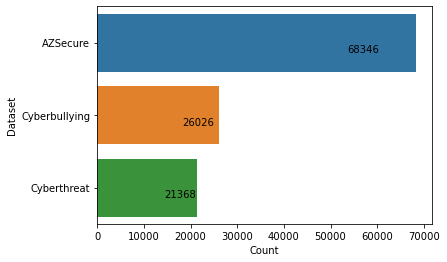

In [124]:
labels = combined_db['dataset'].value_counts().index
values = combined_db['dataset'].value_counts().values

ax = sns.barplot(x=values, y=labels, data=combined_db)
ax.set(xlabel='Count', ylabel='Dataset')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    width = p.get_width()
    x = p.get_x()
    y = p.get_y()
    ax.text(x + width / 1.2, y + height / 1.5, values[i], ha="center")
plt.show(ax)

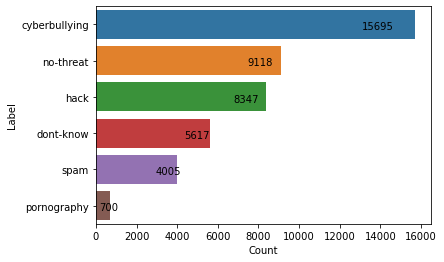

In [115]:
labels = corpus['label'].value_counts().index
values = corpus['label'].value_counts().values

ax = sns.barplot(x=values, y=labels, data=corpus)
ax.set(xlabel='Count', ylabel='Label')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    width = p.get_width()
    x = p.get_x()
    y = p.get_y()
    ax.text(x + width / 1.13, y + height / 1.5, values[i], ha="center")
plt.show(ax)

# AZSecure

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   2%|▏         | 1155/68346 [00:00<00:05, 11549.13it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 68346/68346 [00:28<00:00, 2380.81it/s]


<AxesSubplot:xlabel='words'>

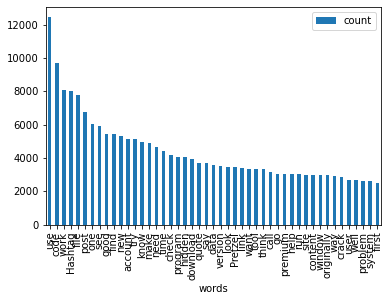

In [12]:
az_secure_result = preprocess_posts(az_secure_db, 'text', replace_patterns=['’'], min_token_length=2, replace_values=['\''], remove_stopwords=True, remove_punctuation=True)

az_secure_vocab_count = az_secure_result['vocab_stats'].most_common(50)
az_secure_vocab_count_df = pd.DataFrame(az_secure_vocab_count)
az_secure_vocab_count_df = az_secure_vocab_count_df[~az_secure_vocab_count_df[0].isin(['[PAD]', '[SEP]', '[CLS]'])]
az_secure_vocab_count_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

az_secure_vocab_count_df.plot.bar(x='words', y='count')

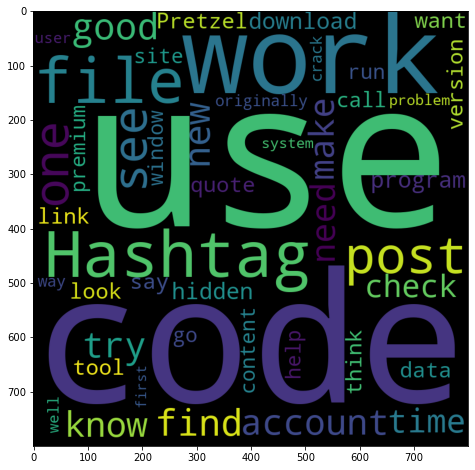

In [13]:
az_secure_vocab_count = { k: v for k, v in az_secure_vocab_count if len(k) > 1 and k not in ['[PAD]', '[CLS]', '[SEP]']}
az_secure_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(az_secure_vocab_count))
plt.figure(figsize=(15,8))
plt.imshow(az_secure_wordcloud)

<AxesSubplot:xlabel='words'>

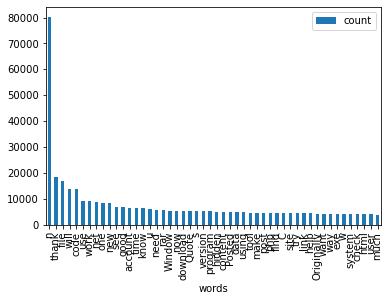

In [41]:
az_secure_non_pre_db = az_secure_database()
az_secure_vocab_count_non_pre_result = dict(word_frequency(az_secure_non_pre_db, 'text'))
az_secure_vocab_count_non_pre_result = { k: v for k, v in az_secure_vocab_count_non_pre_result.items() if len(k) > 1 or k not in ['url', 'number']}

az_secure_vocab_count_non_pre_df = pd.DataFrame(list(az_secure_vocab_count_non_pre_result.items()))
az_secure_vocab_count_non_pre_df.head()
az_secure_vocab_count_non_pre_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

az_secure_vocab_count_non_pre_df.plot.bar(x='words', y='count')

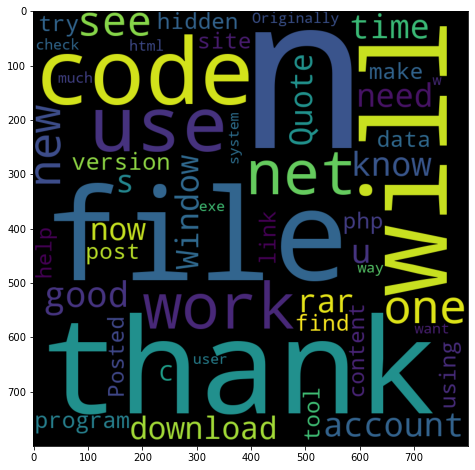

In [42]:
az_secure_non_pre_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(az_secure_vocab_count_non_pre_result))
plt.figure(figsize=(15,8))
plt.imshow(az_secure_non_pre_wordcloud)

# Cyberthreat

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|▏         | 318/21368 [00:00<00:06, 3179.69it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 21368/21368 [00:05<00:00, 3829.43it/s]


<AxesSubplot:xlabel='words'>

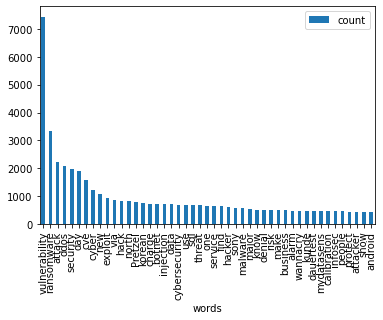

In [16]:
cyberthreat_result = preprocess_posts(cyberthreat_db, 'text', replace_patterns=['’'], min_token_length=2, replace_values=['\''], remove_stopwords=True, remove_punctuation=True)

cyberthreat_vocab_count = cyberthreat_result['vocab_stats'].most_common(50)
cyberthreat_vocab_count_df = pd.DataFrame(cyberthreat_vocab_count)
cyberthreat_vocab_count_df = cyberthreat_vocab_count_df[~cyberthreat_vocab_count_df[0].isin(['[PAD]', '[SEP]', '[CLS]'])]
cyberthreat_vocab_count_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

cyberthreat_vocab_count_df.plot.bar(x='words', y='count')

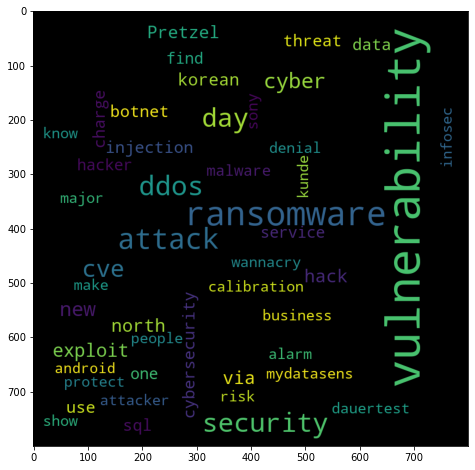

In [17]:
cyberthreat_db_vocab_count = { k: v for k, v in cyberthreat_vocab_count if len(k) > 1 and k not in ['[PAD]', '[CLS]', '[SEP]']}
cyberthreat_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(cyberthreat_db_vocab_count))
plt.figure(figsize=(15,8))
plt.imshow(cyberthreat_wordcloud)

<AxesSubplot:xlabel='words'>

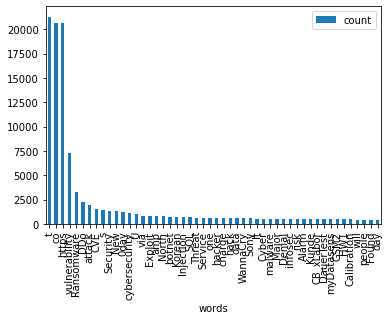

In [43]:
cyberthreat_vocab_count_non_pre_result = dict(word_frequency(cyberthreat_db, 'text'))

cyberthreat_vocab_count_non_pre_df = pd.DataFrame(list(cyberthreat_vocab_count_non_pre_result.items()))
cyberthreat_vocab_count_non_pre_df.head()
cyberthreat_vocab_count_non_pre_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

cyberthreat_vocab_count_non_pre_df.plot.bar(x='words', y='count')

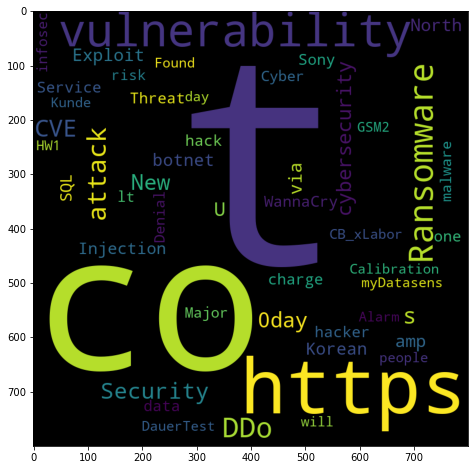

In [44]:
cyberthreat_non_pre_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(cyberthreat_vocab_count_non_pre_result))
plt.figure(figsize=(15,8))
plt.imshow(cyberthreat_non_pre_wordcloud)

# Cyberbullying

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 267/25947 [00:00<00:09, 2615.58it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 25947/25947 [00:07<00:00, 3327.39it/s]


<AxesSubplot:xlabel='words'>

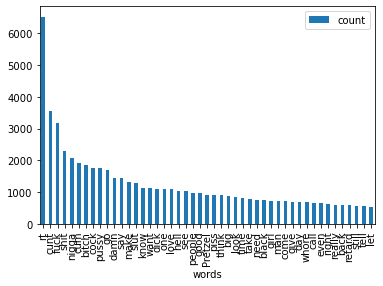

In [20]:
cyberbullying_result = preprocess_posts(cyberbullying_db, 'text', replace_patterns=['’'], min_token_length=2, replace_values=['\''], remove_stopwords=True, remove_punctuation=True)

cyberbullying_db_vocab_count = cyberbullying_result['vocab_stats'].most_common(50)
cyberbullying_db_vocab_count_df = pd.DataFrame(cyberbullying_db_vocab_count)
cyberbullying_db_vocab_count_df = cyberbullying_db_vocab_count_df[~cyberbullying_db_vocab_count_df[0].isin(['[PAD]', '[SEP]', '[CLS]'])]
cyberbullying_db_vocab_count_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

cyberbullying_db_vocab_count_df.plot.bar(x='words', y='count')

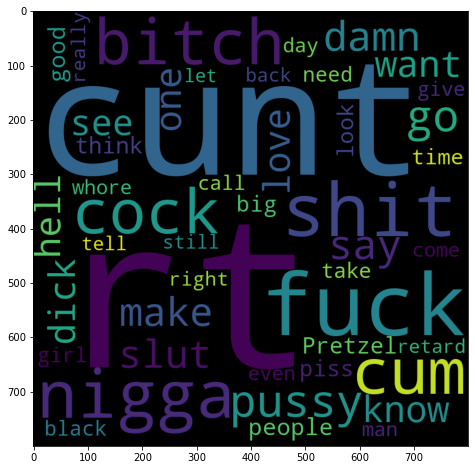

In [21]:
cyberbullying_db_vocab_count = { k: v for k, v in cyberbullying_db_vocab_count if len(k) > 1 and k not in ['[PAD]', '[CLS]', '[SEP]']}
cyberbullying_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(cyberbullying_db_vocab_count))
plt.figure(figsize=(15,8))
plt.imshow(cyberbullying_wordcloud)

<AxesSubplot:xlabel='words'>

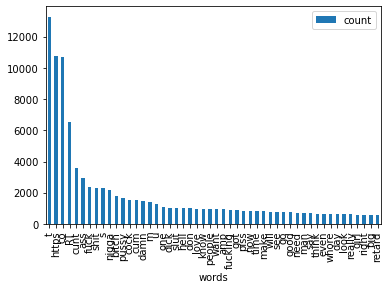

In [45]:
cyberbullying_vocab_count_non_pre_result = dict(word_frequency(cyberbullying_db, 'text'))
cyberbullying_vocab_count_non_pre_df = pd.DataFrame(list(cyberbullying_vocab_count_non_pre_result.items()))
cyberbullying_vocab_count_non_pre_df.head()
cyberbullying_vocab_count_non_pre_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

cyberbullying_vocab_count_non_pre_df.plot.bar(x='words', y='count')

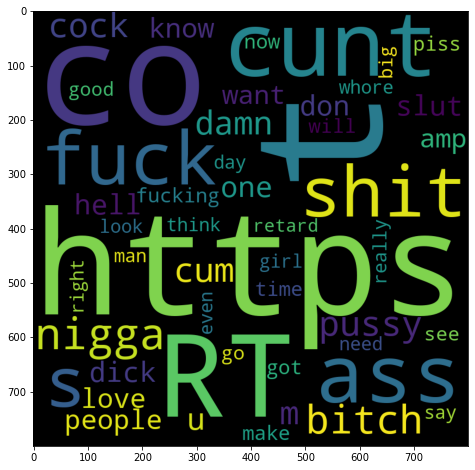

In [46]:
cyberbullying_non_pre_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(cyberbullying_vocab_count_non_pre_result))
plt.figure(figsize=(15,8))
plt.imshow(cyberbullying_non_pre_wordcloud)

# All dataset

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 1174/115659 [00:00<00:09, 11736.35it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 115659/115659 [00:42<00:00, 2748.42it/s]


<AxesSubplot:xlabel='words'>

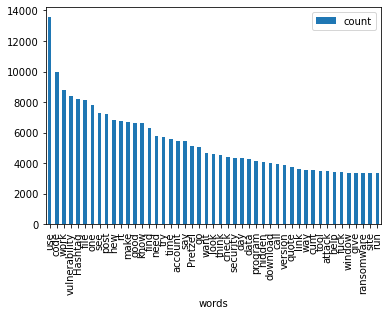

In [24]:
result = preprocess_posts(corpus, 'text', replace_patterns=['’'], min_token_length=2, replace_values=['\''], remove_stopwords=True, remove_punctuation=True)

vocab_count = result['vocab_stats'].most_common(50)
vocab_count_df = pd.DataFrame(vocab_count)
vocab_count_df = vocab_count_df[~vocab_count_df[0].isin(['[PAD]', '[SEP]', '[CLS]'])]
vocab_count_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

vocab_count_df.plot.bar(x='words', y='count')

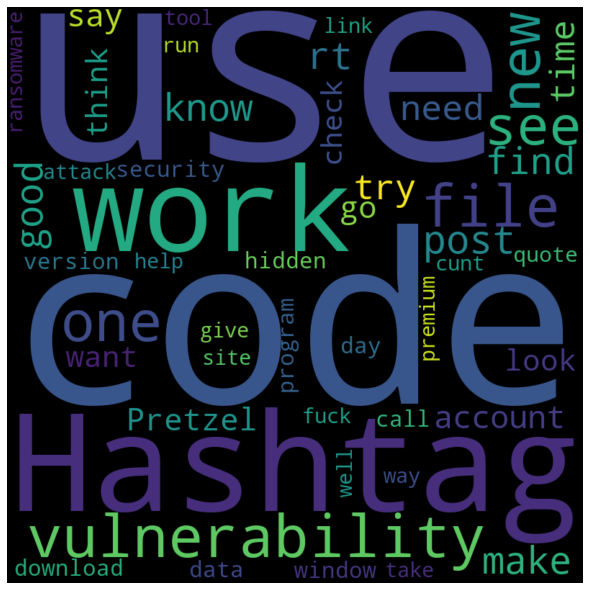

In [25]:
doc = " ".join(result['preprocessed_text'])
plot_wordcloud(doc, max_words=50, use_stopwords_pack=True, stopwords=['SEP', 'PAD', 'CLS'])

<AxesSubplot:xlabel='words'>

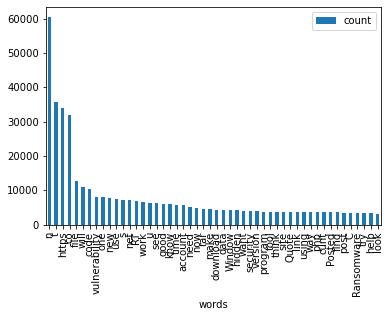

In [47]:
corpus_vocab_count_non_pre_result = dict(word_frequency(corpus, 'text'))
corpus_vocab_count_non_pre_df = pd.DataFrame(list(corpus_vocab_count_non_pre_result.items()))
corpus_vocab_count_non_pre_df.head()
corpus_vocab_count_non_pre_df.rename(columns={0: 'words', 1: 'count'}, inplace=True)

corpus_vocab_count_non_pre_df.plot.bar(x='words', y='count')

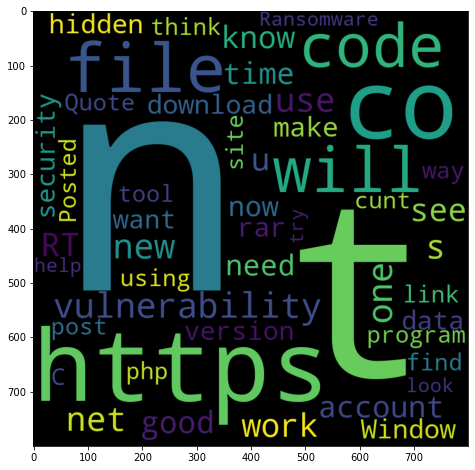

In [48]:
corpus_non_pre_wordcloud = WordCloud(width=800, height=800, collocations=False).generate_from_frequencies(dict(corpus_vocab_count_non_pre_result))
plt.figure(figsize=(15,8))
plt.imshow(corpus_non_pre_wordcloud)